# **Import Libraries**

In [16]:
import numpy as np
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


# **Load and preprocess CIFAR-10 dataset**

In [17]:
def load_and_preprocess_cifar10(input_shape, test_size=0.4, random_state=42):
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=test_size, random_state=random_state)
    val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=random_state)

    img_rows, img_cols, channels = input_shape
    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, channels)
    val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, channels)
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, channels)

    # Convert pixel values to float
    train_images = train_images.astype('float32')
    val_images = val_images.astype('float32')
    test_images = test_images.astype('float32')

    #Normalizing
    mean = np.mean(train_images)
    std = np.std(train_images)

    train_images = (train_images - mean) / std
    val_images = (val_images - mean) / std
    test_images = (test_images - mean) / std

    train_labels = to_categorical(train_labels, num_classes)
    val_labels = to_categorical(val_labels, num_classes)
    test_labels = to_categorical(test_labels, num_classes)

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)



# **Build the CNN Model**

In [18]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_custom_cnn_model(input_shape, wd=1e-4):
    input_tensor = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, (7, 7), padding='same', kernel_regularizer=regularizers.l2(wd))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks
    for _ in range(3):
        x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(wd))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(wd))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    for _ in range(3):
        x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(wd))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(wd))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    for _ in range(3):
        x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(wd))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(wd))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    return model


# **Plot Training and Validation Loss & Accuracy**

In [19]:
def plot_training_history(history, learning_rate):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Learning Rate: {learning_rate}')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Learning Rate: {learning_rate}')
    plt.show()

# **Train and Evaluate the Model**

In [20]:
def train_and_evaluate_model(model, train_images, train_labels, val_images, val_labels, test_images, test_labels, learning_rate, epochs=20):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=epochs, validation_data=(val_images, val_labels))

    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    print(f'Learning Rate: {learning_rate}')
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

    test_predictions = model.predict(test_images)
    test_labels = np.argmax(test_labels, axis=1)
    test_predictions = np.argmax(test_predictions, axis=1)

    confusion = confusion_matrix(test_labels, test_predictions)
    print("Confusion Matrix:")
    print(confusion)

    precision = precision_score(test_labels, test_predictions, average='macro')
    recall = recall_score(test_labels, test_predictions, average='macro')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    plot_training_history(history, learning_rate)



# **Load the CIFAR-10 dataset(From Keras)**

In [21]:
num_classes = 10
input_shape = (32, 32, 3)

In [22]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_and_preprocess_cifar10(input_shape)


# **List of learning rates to test**

In [23]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]

# **Train and evaluate the model for different learning rates**

Training and evaluating the model with learning rate: 0.0001
Epoch 1/20
938/938 [==============================] - 49s 40ms/step - loss: 2.0015 - accuracy: 0.3610 - val_loss: 1.6234 - val_accuracy: 0.5029
Epoch 2/20
938/938 [==============================] - 36s 38ms/step - loss: 1.6130 - accuracy: 0.5251 - val_loss: 1.8284 - val_accuracy: 0.4536
Epoch 3/20
938/938 [==============================] - 36s 38ms/step - loss: 1.4035 - accuracy: 0.6005 - val_loss: 1.4511 - val_accuracy: 0.5816
Epoch 4/20
938/938 [==============================] - 37s 40ms/step - loss: 1.2532 - accuracy: 0.6584 - val_loss: 1.2850 - val_accuracy: 0.6414
Epoch 5/20
938/938 [==============================] - 37s 40ms/step - loss: 1.1149 - accuracy: 0.7086 - val_loss: 1.4095 - val_accuracy: 0.6302
Epoch 6/20
938/938 [==============================] - 37s 40ms/step - loss: 1.0110 - accuracy: 0.7443 - val_loss: 1.3162 - val_accuracy: 0.6573
Epoch 7/20
938/938 [==============================] - 36s 38ms/step - loss:

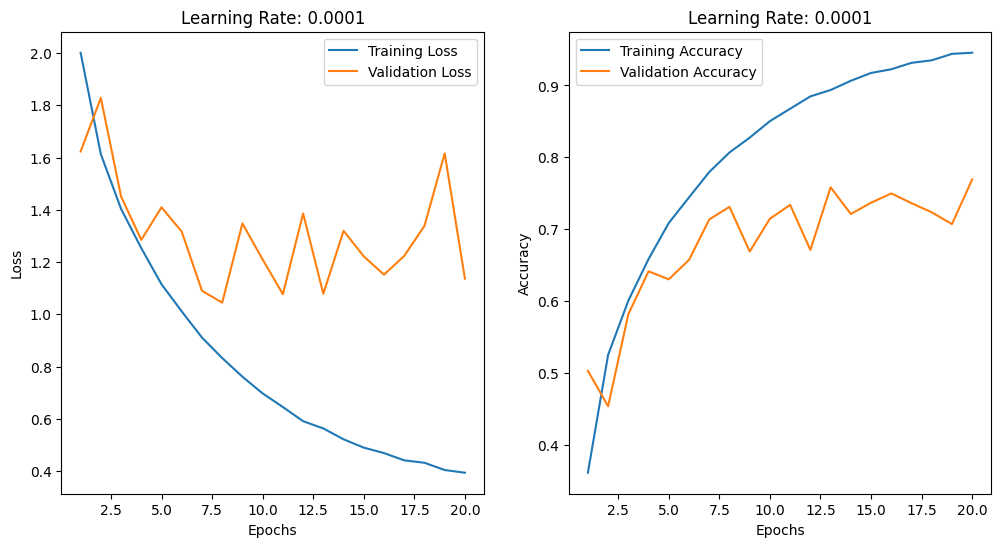

Training and evaluating the model with learning rate: 0.001
Epoch 1/20
938/938 [==============================] - 50s 41ms/step - loss: 2.1980 - accuracy: 0.1977 - val_loss: 2.6386 - val_accuracy: 0.2028
Epoch 2/20
938/938 [==============================] - 36s 38ms/step - loss: 1.9884 - accuracy: 0.2553 - val_loss: 3.0977 - val_accuracy: 0.1885
Epoch 3/20
938/938 [==============================] - 37s 40ms/step - loss: 1.9135 - accuracy: 0.2899 - val_loss: 2.0454 - val_accuracy: 0.2166
Epoch 4/20
938/938 [==============================] - 36s 38ms/step - loss: 1.8769 - accuracy: 0.3026 - val_loss: 1.9660 - val_accuracy: 0.2746
Epoch 5/20
938/938 [==============================] - 38s 40ms/step - loss: 1.8455 - accuracy: 0.3171 - val_loss: 1.8149 - val_accuracy: 0.3067
Epoch 6/20
938/938 [==============================] - 38s 40ms/step - loss: 1.8138 - accuracy: 0.3312 - val_loss: 4.7861 - val_accuracy: 0.1951
Epoch 7/20
938/938 [==============================] - 38s 40ms/step - loss: 

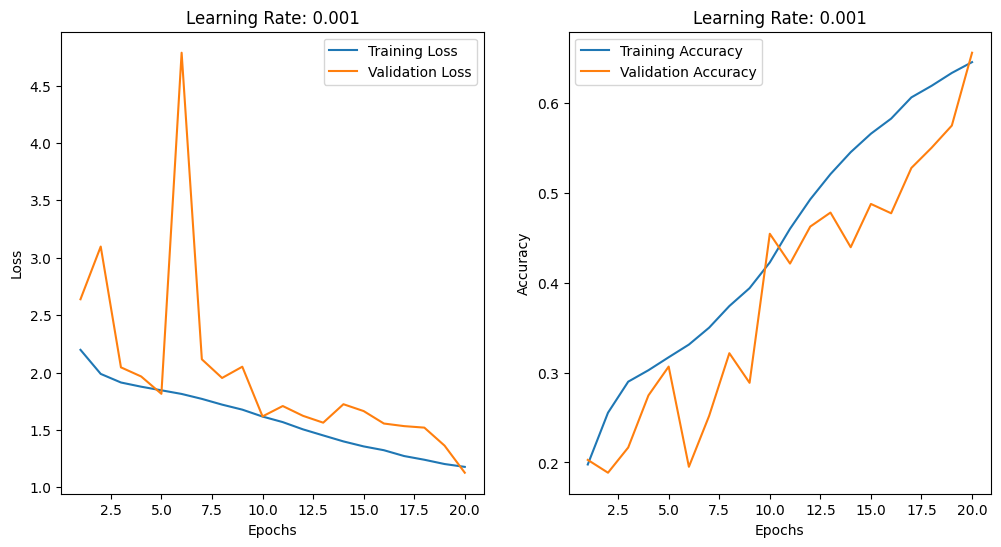

Training and evaluating the model with learning rate: 0.01
Epoch 1/20
938/938 [==============================] - 49s 39ms/step - loss: 2.5723 - accuracy: 0.1504 - val_loss: 2.8535 - val_accuracy: 0.1095
Epoch 2/20
938/938 [==============================] - 36s 38ms/step - loss: 2.2673 - accuracy: 0.1743 - val_loss: 2.6669 - val_accuracy: 0.0950
Epoch 3/20
938/938 [==============================] - 38s 40ms/step - loss: 2.1261 - accuracy: 0.1811 - val_loss: 2.4790 - val_accuracy: 0.1091
Epoch 4/20
938/938 [==============================] - 38s 40ms/step - loss: 2.0891 - accuracy: 0.1793 - val_loss: 3.3561 - val_accuracy: 0.0955
Epoch 5/20
938/938 [==============================] - 36s 38ms/step - loss: 2.0565 - accuracy: 0.1880 - val_loss: 3.2959 - val_accuracy: 0.0950
Epoch 6/20
938/938 [==============================] - 38s 40ms/step - loss: 2.0393 - accuracy: 0.1927 - val_loss: 3.0834 - val_accuracy: 0.0856
Epoch 7/20
938/938 [==============================] - 37s 40ms/step - loss: 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


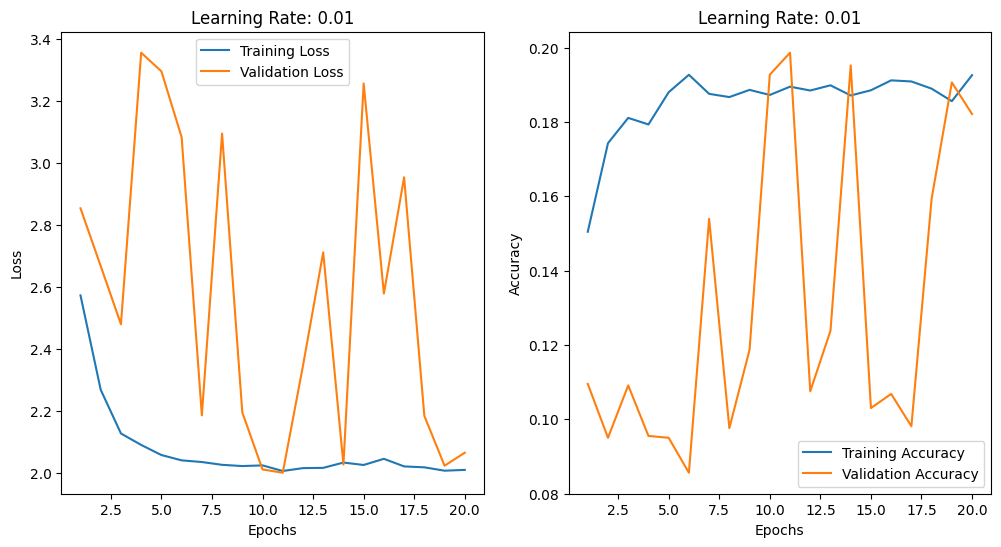

Training and evaluating the model with learning rate: 0.1
Epoch 1/20
938/938 [==============================] - 49s 41ms/step - loss: 38.2380 - accuracy: 0.0978 - val_loss: 40.9640 - val_accuracy: 0.0950
Epoch 2/20
938/938 [==============================] - 37s 40ms/step - loss: 19.9664 - accuracy: 0.0989 - val_loss: 10.4084 - val_accuracy: 0.1030
Epoch 3/20
938/938 [==============================] - 35s 38ms/step - loss: 7.2102 - accuracy: 0.0978 - val_loss: 5.0682 - val_accuracy: 0.0950
Epoch 4/20
938/938 [==============================] - 37s 39ms/step - loss: 4.0541 - accuracy: 0.0993 - val_loss: 3.3296 - val_accuracy: 0.1030
Epoch 5/20
938/938 [==============================] - 37s 40ms/step - loss: 2.9572 - accuracy: 0.1017 - val_loss: 2.6954 - val_accuracy: 0.0953
Epoch 6/20
938/938 [==============================] - 37s 39ms/step - loss: 2.5470 - accuracy: 0.0991 - val_loss: 2.4379 - val_accuracy: 0.1085
Epoch 7/20
938/938 [==============================] - 37s 39ms/step - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


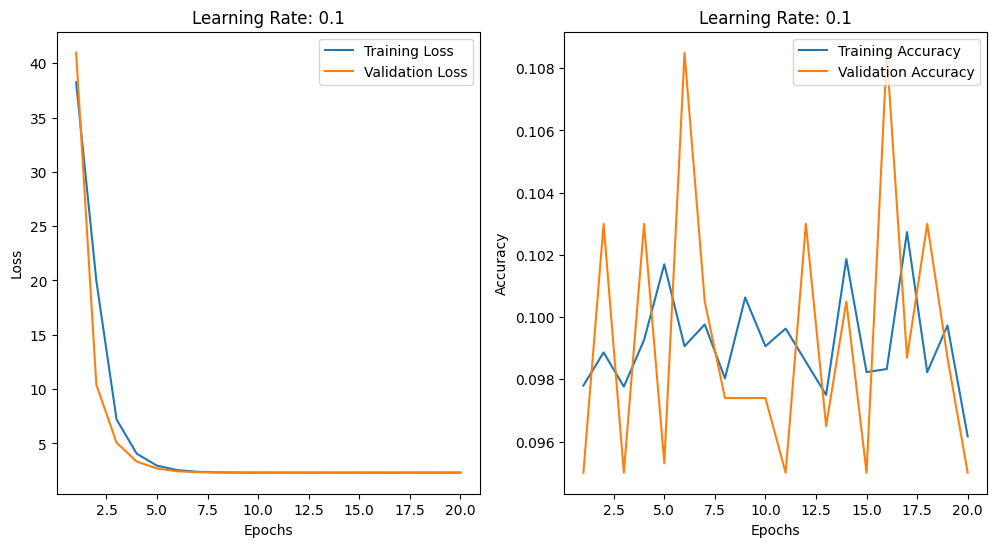

In [24]:
for lr in learning_rates:
    print(f"Training and evaluating the model with learning rate: {lr}")
    model = build_custom_cnn_model(input_shape, wd=1e-4)
    train_and_evaluate_model(model, train_images, train_labels, val_images, val_labels, test_images, test_labels, lr)

# **Fine-Tuned Pre-trained Model for CIFAR-10 Classification.**

In [25]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout
from keras.models import Model

# **ResNet**

In [26]:
from keras.applications import ResNet50

In [14]:
def fine_tune_resnet50():
    # Load the ResNet-50 model pre-trained on ImageNet, excluding the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False)

    # Add custom layers for CIFAR-10 classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create a new model by combining the base model and custom layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers in the base model and train only the custom layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

# **Train and evaluate the fine-tuned ResNet models for different learning rates for lr in learning_rates:**

Training and evaluating the model with learning rate: 0.0001
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20
938/938 [==============================] - 23s 20ms/step - loss: 2.0232 - accuracy: 0.2853 - val_loss: 1.7590 - val_accuracy: 0.3763
Epoch 2/20
938/938 [==============================] - 17s 18ms/step - loss: 1.7733 - accuracy: 0.3651 - val_loss: 1.6776 - val_accuracy: 0.4073
Epoch 3/20
938/938 [==============================] - 17s 18ms/step - loss: 1.7049 - accuracy: 0.3959 - val_loss: 1.6416 - val_accuracy: 0.4205
Epoch 4/20
938/938 [==============================] - 17s 19ms/step - loss: 1.6555 - accuracy: 0.4111 - val_loss: 1.6322 - val_accuracy: 0.4214
Epoch 5/20
938/938 [==============================] - 16s 17ms/step - loss: 1.6240 - accuracy: 0.4275 - val_loss: 1.5951 - val_accuracy: 0.4386
Epoch 6/20
938/938 [==============================] - 15s 16ms/step - loss: 1.5970 - accuracy: 0.4355 - val_loss: 1.5755 - val_accuracy: 0.4517
Epoch 7/20

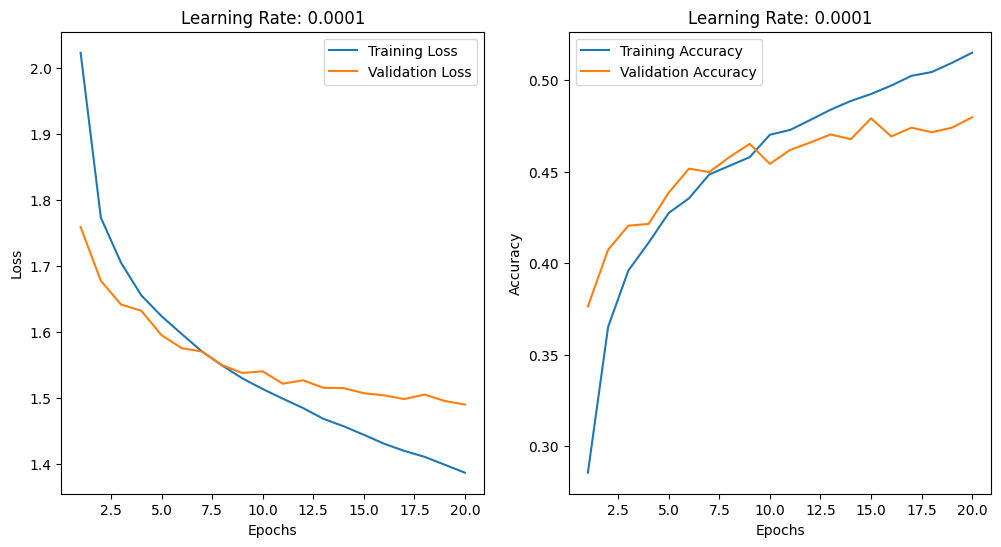

Training and evaluating the model with learning rate: 0.001
Epoch 1/20
938/938 [==============================] - 20s 18ms/step - loss: 1.9325 - accuracy: 0.3099 - val_loss: 1.7510 - val_accuracy: 0.3797
Epoch 2/20
938/938 [==============================] - 15s 16ms/step - loss: 1.7894 - accuracy: 0.3542 - val_loss: 1.7043 - val_accuracy: 0.3816
Epoch 3/20
938/938 [==============================] - 17s 18ms/step - loss: 1.7452 - accuracy: 0.3757 - val_loss: 1.6530 - val_accuracy: 0.4077
Epoch 4/20
938/938 [==============================] - 15s 16ms/step - loss: 1.7162 - accuracy: 0.3869 - val_loss: 1.6342 - val_accuracy: 0.4067
Epoch 5/20
938/938 [==============================] - 15s 16ms/step - loss: 1.6988 - accuracy: 0.3948 - val_loss: 1.6093 - val_accuracy: 0.4258
Epoch 6/20
938/938 [==============================] - 17s 18ms/step - loss: 1.6649 - accuracy: 0.4057 - val_loss: 1.6239 - val_accuracy: 0.4214
Epoch 7/20
938/938 [==============================] - 15s 16ms/step - loss: 

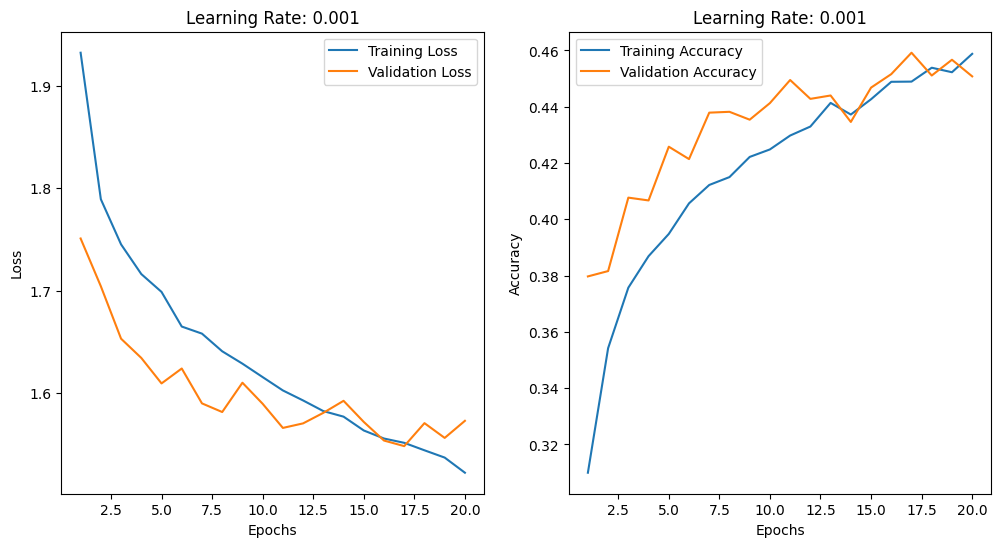

Training and evaluating the model with learning rate: 0.01
Epoch 1/20
938/938 [==============================] - 20s 18ms/step - loss: 2.3453 - accuracy: 0.1710 - val_loss: 2.1445 - val_accuracy: 0.1689
Epoch 2/20
938/938 [==============================] - 17s 18ms/step - loss: 2.2181 - accuracy: 0.1491 - val_loss: 2.0544 - val_accuracy: 0.2217
Epoch 3/20
938/938 [==============================] - 15s 16ms/step - loss: 2.2068 - accuracy: 0.1565 - val_loss: 2.1266 - val_accuracy: 0.1856
Epoch 4/20
938/938 [==============================] - 15s 16ms/step - loss: 2.1773 - accuracy: 0.1634 - val_loss: 2.0360 - val_accuracy: 0.2514
Epoch 5/20
938/938 [==============================] - 15s 16ms/step - loss: 2.1678 - accuracy: 0.1672 - val_loss: 2.0017 - val_accuracy: 0.2641
Epoch 6/20
938/938 [==============================] - 15s 16ms/step - loss: 2.1667 - accuracy: 0.1711 - val_loss: 2.0561 - val_accuracy: 0.2256
Epoch 7/20
938/938 [==============================] - 15s 16ms/step - loss: 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


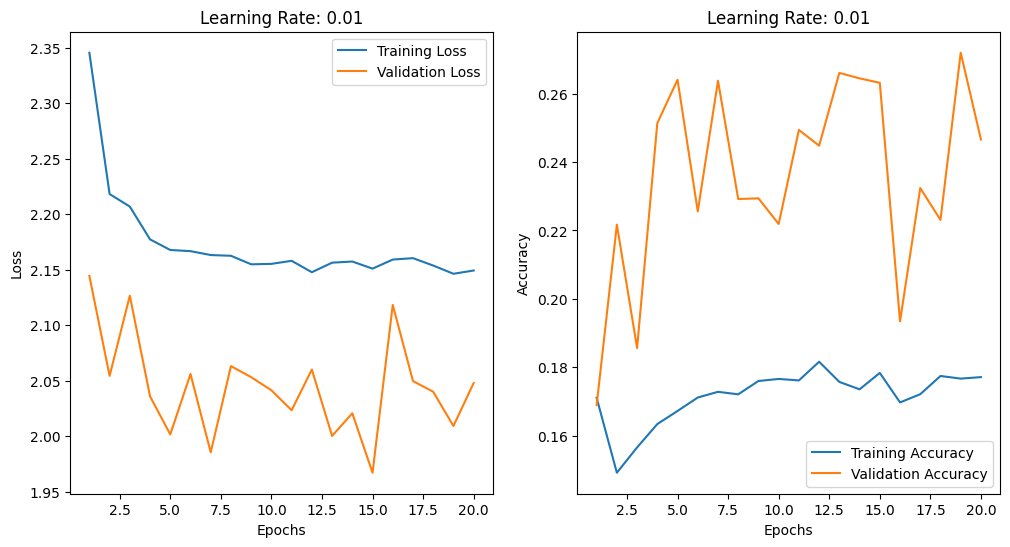

Training and evaluating the model with learning rate: 0.1
Epoch 1/20
938/938 [==============================] - 23s 20ms/step - loss: 5.8965 - accuracy: 0.1005 - val_loss: 2.3338 - val_accuracy: 0.0952
Epoch 2/20
938/938 [==============================] - 16s 17ms/step - loss: 2.4705 - accuracy: 0.0991 - val_loss: 2.3143 - val_accuracy: 0.0965
Epoch 3/20
938/938 [==============================] - 18s 19ms/step - loss: 2.4821 - accuracy: 0.1023 - val_loss: 2.3129 - val_accuracy: 0.1085
Epoch 4/20
938/938 [==============================] - 18s 19ms/step - loss: 2.4493 - accuracy: 0.0999 - val_loss: 2.3192 - val_accuracy: 0.0974
Epoch 5/20
938/938 [==============================] - 18s 19ms/step - loss: 2.3202 - accuracy: 0.0979 - val_loss: 2.3217 - val_accuracy: 0.1005
Epoch 6/20
938/938 [==============================] - 18s 19ms/step - loss: 2.3153 - accuracy: 0.1028 - val_loss: 2.3171 - val_accuracy: 0.0953
Epoch 7/20
938/938 [==============================] - 18s 19ms/step - loss: 2.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


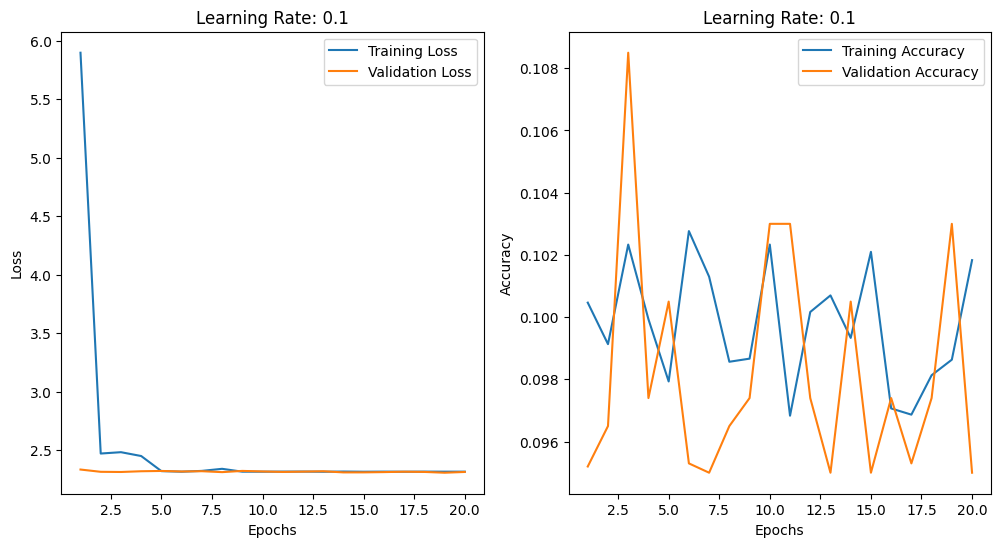

In [15]:
for lr in learning_rates:
    print(f"Training and evaluating the model with learning rate: {lr}")
    model = fine_tune_resnet50()
    train_and_evaluate_model(model, train_images, train_labels, val_images, val_labels, test_images, test_labels, lr)

# **DenseNet**

In [27]:
from keras.applications import DenseNet121

In [11]:
def fine_tune_densenet121():
    # Load the DenseNet-121 model pre-trained on ImageNet, excluding the top classification layer
    base_model = DenseNet121(weights='imagenet', include_top=False)

    # Add custom layers for CIFAR-10 classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create a new model by combining the base model and custom layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers in the base model and train only the custom layers
    for layer in base_model.layers:
        layer.trainable = False

    return model


# **Train and evaluate the fine-tuned DenseNet models for different learning rates for lr in learning_rates:**

Training and evaluating the model with learning rate: 0.0001
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/20
938/938 [==============================] - 29s 22ms/step - loss: 1.5283 - accuracy: 0.4912 - val_loss: 1.0726 - val_accuracy: 0.6252
Epoch 2/20
938/938 [==============================] - 19s 21ms/step - loss: 1.1189 - accuracy: 0.6091 - val_loss: 0.9876 - val_accuracy: 0.6539
Epoch 3/20
938/938 [==============================] - 21s 22ms/step - loss: 1.0017 - accuracy: 0.6483 - val_loss: 0.9395 - val_accuracy: 0.6690
Epoch 4/20
938/938 [==============================] - 19s 20ms/step - loss: 0.9255 - accuracy: 0.6733 - val_loss: 0.9216 - val_accuracy: 0.6783
Epoch 5/20
938/938 [==============================] - 18s 19ms/step - loss: 0.8765 - accuracy: 0.6926 - val_loss: 0.9033 - val_accuracy: 0.6869
Epoch 6/20
938/938 [==============================] - 18s 19ms/step - loss: 0.8272 - accuracy: 0.7100 - val_loss: 0.8859 - val_accuracy: 0.6883
Epoch 7/20

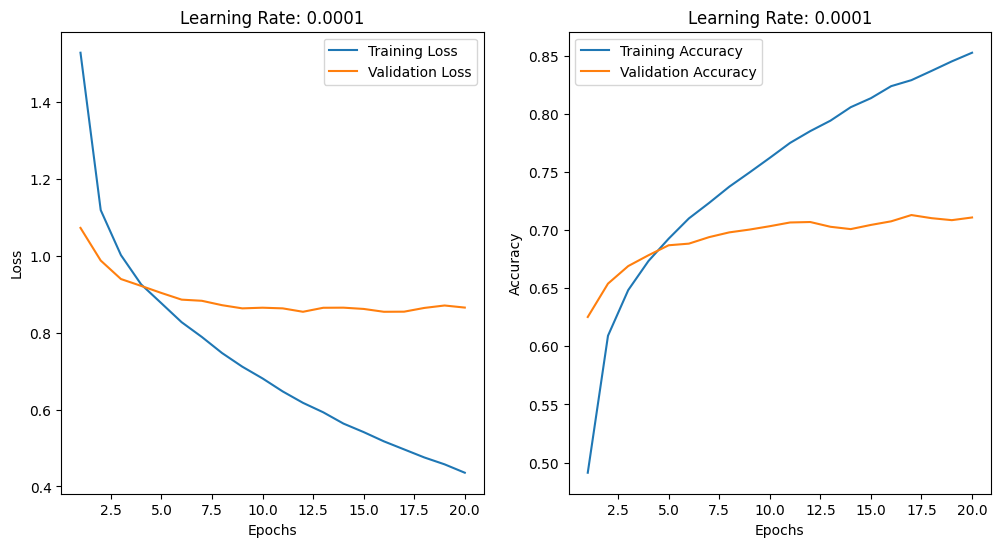

Training and evaluating the model with learning rate: 0.001
Epoch 1/20
938/938 [==============================] - 29s 24ms/step - loss: 1.3019 - accuracy: 0.5551 - val_loss: 1.0147 - val_accuracy: 0.6400
Epoch 2/20
938/938 [==============================] - 20s 21ms/step - loss: 1.0799 - accuracy: 0.6200 - val_loss: 0.9660 - val_accuracy: 0.6580
Epoch 3/20
938/938 [==============================] - 18s 20ms/step - loss: 1.0275 - accuracy: 0.6381 - val_loss: 0.9660 - val_accuracy: 0.6604
Epoch 4/20
938/938 [==============================] - 20s 21ms/step - loss: 0.9762 - accuracy: 0.6546 - val_loss: 0.9232 - val_accuracy: 0.6750
Epoch 5/20
938/938 [==============================] - 20s 21ms/step - loss: 0.9384 - accuracy: 0.6710 - val_loss: 0.9268 - val_accuracy: 0.6796
Epoch 6/20
938/938 [==============================] - 20s 21ms/step - loss: 0.9086 - accuracy: 0.6774 - val_loss: 0.9520 - val_accuracy: 0.6690
Epoch 7/20
938/938 [==============================] - 18s 19ms/step - loss: 

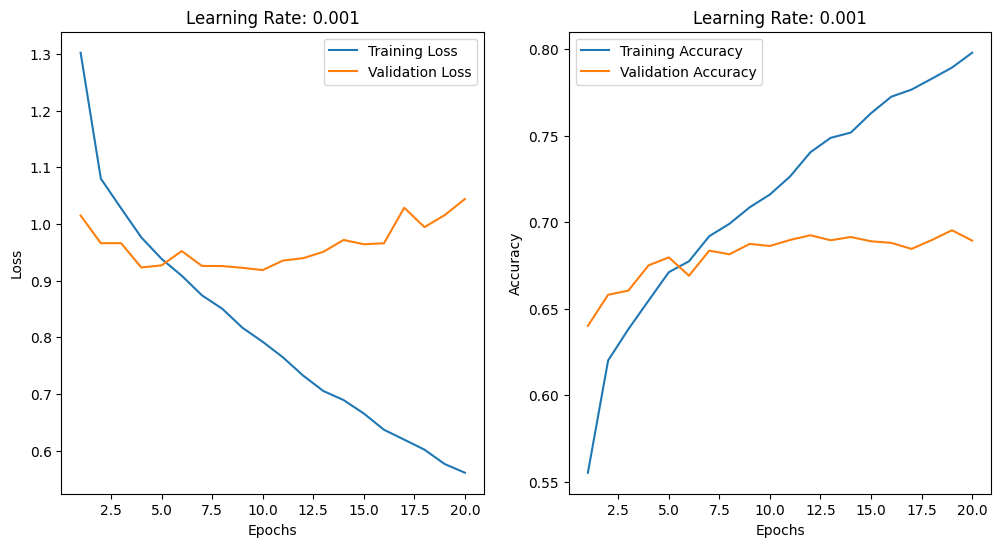

Training and evaluating the model with learning rate: 0.01
Epoch 1/20
938/938 [==============================] - 30s 24ms/step - loss: 1.9465 - accuracy: 0.3840 - val_loss: 1.4350 - val_accuracy: 0.4825
Epoch 2/20
938/938 [==============================] - 20s 21ms/step - loss: 1.7861 - accuracy: 0.3721 - val_loss: 1.4856 - val_accuracy: 0.4985
Epoch 3/20
938/938 [==============================] - 20s 21ms/step - loss: 1.7798 - accuracy: 0.3673 - val_loss: 1.5180 - val_accuracy: 0.4701
Epoch 4/20
938/938 [==============================] - 20s 21ms/step - loss: 1.7797 - accuracy: 0.3670 - val_loss: 1.5158 - val_accuracy: 0.4576
Epoch 5/20
938/938 [==============================] - 18s 20ms/step - loss: 1.7511 - accuracy: 0.3784 - val_loss: 1.4778 - val_accuracy: 0.5006
Epoch 6/20
938/938 [==============================] - 20s 21ms/step - loss: 1.7232 - accuracy: 0.3854 - val_loss: 1.5240 - val_accuracy: 0.4707
Epoch 7/20
938/938 [==============================] - 20s 21ms/step - loss: 1

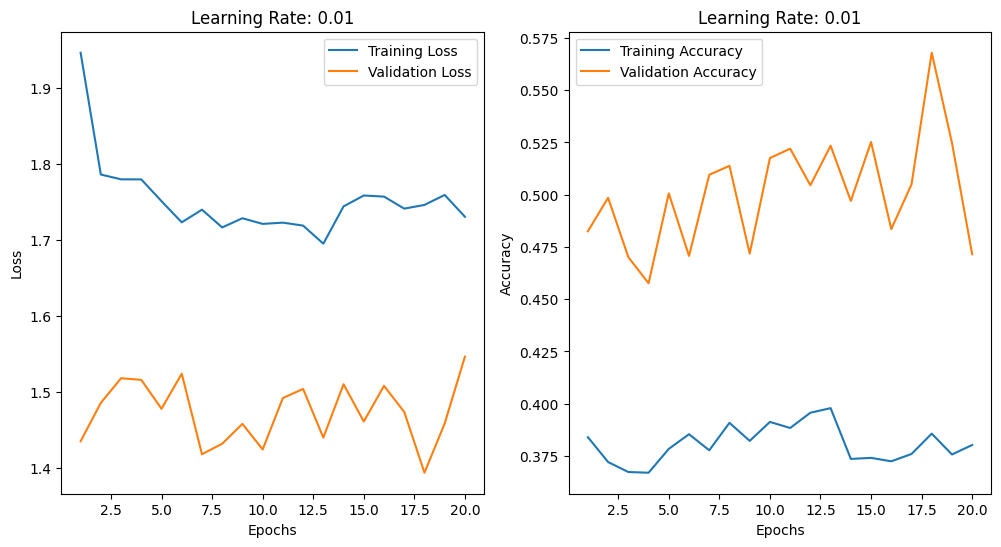

Training and evaluating the model with learning rate: 0.1
Epoch 1/20
938/938 [==============================] - 29s 25ms/step - loss: 10.5829 - accuracy: 0.1031 - val_loss: 2.3145 - val_accuracy: 0.0950
Epoch 2/20
938/938 [==============================] - 20s 21ms/step - loss: 2.3955 - accuracy: 0.0986 - val_loss: 2.3062 - val_accuracy: 0.1031
Epoch 3/20
938/938 [==============================] - 19s 20ms/step - loss: 2.5111 - accuracy: 0.0992 - val_loss: 2.3137 - val_accuracy: 0.1005
Epoch 4/20
938/938 [==============================] - 19s 20ms/step - loss: 2.3469 - accuracy: 0.1022 - val_loss: 2.3071 - val_accuracy: 0.1005
Epoch 5/20
938/938 [==============================] - 20s 21ms/step - loss: 2.3163 - accuracy: 0.0990 - val_loss: 2.3104 - val_accuracy: 0.0965
Epoch 6/20
938/938 [==============================] - 19s 20ms/step - loss: 2.3165 - accuracy: 0.0988 - val_loss: 2.3132 - val_accuracy: 0.1030
Epoch 7/20
938/938 [==============================] - 20s 22ms/step - loss: 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


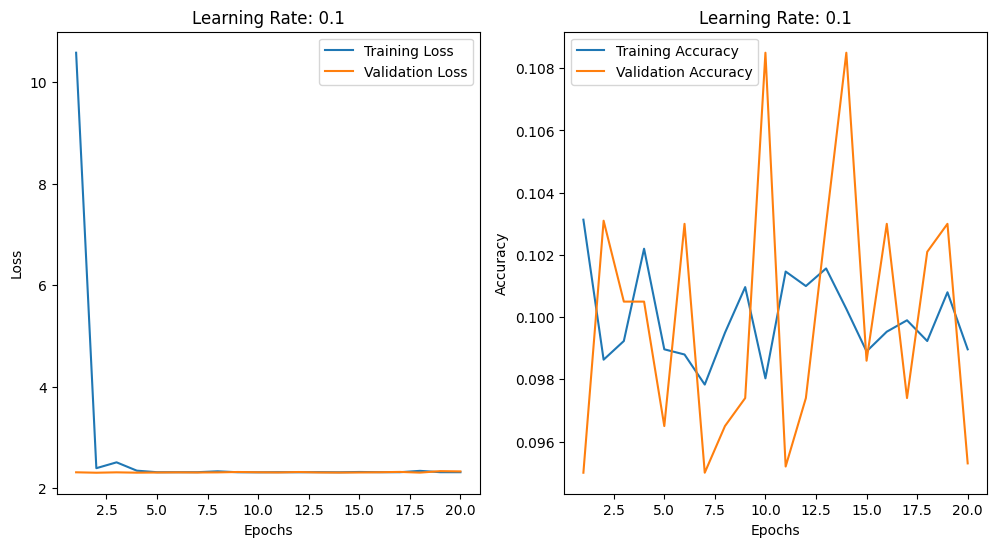

In [12]:
for lr in learning_rates:
    print(f"Training and evaluating the model with learning rate: {lr}")
    model = fine_tune_densenet121()
    train_and_evaluate_model(model, train_images, train_labels, val_images, val_labels, test_images, test_labels, lr)